In [1]:
# Suppressing warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# System and Random Utilities
import os
import random

from pathlib import Path
import warnings

# import lightning.pytorch as pl
# from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
# from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb

# Time-Series Analysis Libraries
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
# from pytorch_forecasting.data import GroupNormalizer
# from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
# Set the seed for reproducibility
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Set seed for random module
random.seed(seed_value)

# Set seed for numpy module
np.random.seed(seed_value)

# # Set seed for TensorFlow
# tf.random.set_seed(seed_value)

In [3]:
df = pd.read_csv('../datasets/train.csv')
print(df.shape)
df.head()

(913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
df['date'] = pd.to_datetime(df['date'])

df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

df['weekday'] = df['date'].dt.day_name()
df

,date,store,item,sales,day,month,year,weekday
0,2013-01-01,1,1,13,1,1,2013,Tuesday
1,2013-01-02,1,1,11,2,1,2013,Wednesday
2,2013-01-03,1,1,14,3,1,2013,Thursday
3,2013-01-04,1,1,13,4,1,2013,Friday
4,2013-01-05,1,1,10,5,1,2013,Saturday
...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,27,12,2017,Wednesday
912996,2017-12-28,10,50,59,28,12,2017,Thursday
912997,2017-12-29,10,50,74,29,12,2017,Friday
912998,2017-12-30,10,50,62,30,12,2017,Saturday


In [5]:
start_date = pd.to_datetime('2013-01-01', format='%Y-%m-%d')
df['time_idx'] = (df['date'] - start_date).dt.days + 1
df

,date,store,item,sales,day,month,year,weekday,time_idx
0,2013-01-01,1,1,13,1,1,2013,Tuesday,1
1,2013-01-02,1,1,11,2,1,2013,Wednesday,2
2,2013-01-03,1,1,14,3,1,2013,Thursday,3
3,2013-01-04,1,1,13,4,1,2013,Friday,4
4,2013-01-05,1,1,10,5,1,2013,Saturday,5
...,...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,27,12,2017,Wednesday,1822
912996,2017-12-28,10,50,59,28,12,2017,Thursday,1823
912997,2017-12-29,10,50,74,29,12,2017,Friday,1824
912998,2017-12-30,10,50,62,30,12,2017,Saturday,1825


In [6]:
df_day = df.copy()
df_day = df_day[(df_day['store']==1) &(df_day['item']==1)]
print(df_day.shape)
df_day.head()

(1826, 9)


,date,store,item,sales,day,month,year,weekday,time_idx
0,2013-01-01,1,1,13,1,1,2013,Tuesday,1
1,2013-01-02,1,1,11,2,1,2013,Wednesday,2
2,2013-01-03,1,1,14,3,1,2013,Thursday,3
3,2013-01-04,1,1,13,4,1,2013,Friday,4
4,2013-01-05,1,1,10,5,1,2013,Saturday,5


# Daily Forecasting

In [7]:
df_pretrain = df_day.copy()

df_pretrain = pd.get_dummies(df_pretrain, columns=['month'], prefix='month')
df_pretrain = pd.get_dummies(df_pretrain, columns=['year'], prefix='year')
df_pretrain = pd.get_dummies(df_pretrain, columns=['weekday'], prefix='week_day')

# Columns related to weekdays
weekday_columns = [
    'week_day_Sunday',
    'week_day_Monday',
    'week_day_Tuesday',
    'week_day_Wednesday',
    'week_day_Thursday',
    'week_day_Friday',
    'week_day_Saturday',
]

# Extract and sort the weekday columns based on the custom order
sorted_weekday_columns = sorted(weekday_columns, key=lambda col: weekday_columns.index(col))

# Create a new DataFrame with the sorted weekday columns
df_sorted_weekdays = df_pretrain[sorted_weekday_columns]

# Concatenate the new DataFrame with the remaining columns
df_pretrain = pd.concat([df_pretrain.drop(columns=weekday_columns), df_sorted_weekdays], axis=1)

# Converting boolean columns to integer
df_pretrain[df_pretrain.select_dtypes(include=bool).columns] = df_pretrain.select_dtypes(include=bool).astype(int)


df_pretrain.drop(columns=['store', 'item', 'date', 'day'], inplace=True)
        
df_pretrain.head()

,sales,time_idx,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,year_2015,year_2016,year_2017,week_day_Sunday,week_day_Monday,week_day_Tuesday,week_day_Wednesday,week_day_Thursday,week_day_Friday,week_day_Saturday
0,13,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,11,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,14,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,13,4,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,10,5,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [8]:
# Create lag features for time-series modeling
num_lags = 7  # Number of lag hours for the model
for i in range(1, num_lags + 1):
    df_pretrain[f'sales_lag_{i}'] = df_pretrain['sales'].shift(i)

# Drop rows with NaN values due to the lag operation
df_pretrain = df_pretrain.dropna()
df_pretrain.head()

,sales,time_idx,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,week_day_Thursday,week_day_Friday,week_day_Saturday,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,sales_lag_7
7,9,8,1,0,0,0,0,0,0,0,...,0,0,0,10.0,12.0,10.0,13.0,14.0,11.0,13.0
8,12,9,1,0,0,0,0,0,0,0,...,0,0,0,9.0,10.0,12.0,10.0,13.0,14.0,11.0
9,9,10,1,0,0,0,0,0,0,0,...,1,0,0,12.0,9.0,10.0,12.0,10.0,13.0,14.0
10,9,11,1,0,0,0,0,0,0,0,...,0,1,0,9.0,12.0,9.0,10.0,12.0,10.0,13.0
11,7,12,1,0,0,0,0,0,0,0,...,0,0,1,9.0,9.0,12.0,9.0,10.0,12.0,10.0


In [16]:
pred_len = 7

In [17]:
# Separating target variable 'nb_order' and features
y = df_pretrain['sales']
X = df_pretrain.drop(columns='sales')

# Scaling features and combining with the target variable
df_scaled = pd.DataFrame(np.column_stack([y, X]), columns=['sales'] + X.columns.tolist())

# Split the data into train and test sets
train_size = int(len(df_scaled) - pred_len)  # Test set is 72 hours
train, test = df_scaled[:train_size], df_scaled[train_size:]

# Separate features and target variable
X_train, y_train = train.drop(columns='sales').values, train['sales'].values
X_test, y_test = test.drop(columns='sales').values, test['sales'].values

In [18]:
# Set hyperparameters
model = lgb.LGBMRegressor(
    force_col_wise=True,
    learning_rate=0.5,
    n_estimators=100,
    # min_data_in_leaf = 0
    )

# Train the model
model.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 1812, number of used features: 32
[LightGBM] [Info] Start training from score 20.009934


LGBMRegressor(force_col_wise=True, learning_rate=0.5)

In [19]:
test.columns

Index(['sales', 'time_idx', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'year_2013', 'year_2014', 'year_2015',
       'year_2016', 'year_2017', 'week_day_Sunday', 'week_day_Monday',
       'week_day_Tuesday', 'week_day_Wednesday', 'week_day_Thursday',
       'week_day_Friday', 'week_day_Saturday', 'sales_lag_1', 'sales_lag_2',
       'sales_lag_3', 'sales_lag_4', 'sales_lag_5', 'sales_lag_6',
       'sales_lag_7'],
      dtype='object')

In [20]:
# Initialize an empty list to store forecasted values
forecast_values = []

# Initialize the current sequence with the first row of the test set
current_sequence = X_test[0:1]

# Loop to predict the next 72 hours 
for _ in range(pred_len):
    # print(current_sequence)

    # Predict the next hour's value using the trained model
    next_hour_pred = model.predict(current_sequence)
    
    # Append the prediction to the forecast values
    forecast_values.append(next_hour_pred[0])


    next_month_pred = model.predict(current_sequence)
    time_idx = current_sequence[0][0] + 1
    month_seq = current_sequence[0][1:13] 
    year_seq = current_sequence[0][13:18]
    weekday_seq = current_sequence[0][18:25]

    if weekday_seq[-1] == 1:
        weekday_seq[0], weekday_seq[-1] = 1, 0
    else:
        weekday_seq = np.roll(weekday_seq, 1)

    current_sequence_lag = current_sequence[0][25:]
    current_sequence_lag = np.roll(current_sequence_lag, 1)
    current_sequence_lag[0] = next_month_pred[0]

    current_sequence = [np.concatenate(([time_idx], month_seq, year_seq, weekday_seq, current_sequence_lag))]
    
prediction = forecast_values

In [21]:
# Function to evaluate model performance
def evaluate_model(y_test, prediction):
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    rmse = np.sqrt(mse)  # Calculate RMSE
    r_squared = r2_score(y_test, prediction)  # Calculate R-squared

    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R-squared: {r_squared}")

# Function to plot actual vs. predicted values
def plot_predictions(testing_hours, y_test, prediction):
  df_test = pd.DataFrame({"hour": testing_hours, "actual": y_test, "prediction": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="hour", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="hour", y="prediction")
  plt.title("Actual vs. Predicted")
  plt.xlabel("Hour of day")
  plt.ylabel("Number of Orders")
  plt.legend(["Actual", "Prediction"])
  plt.show()

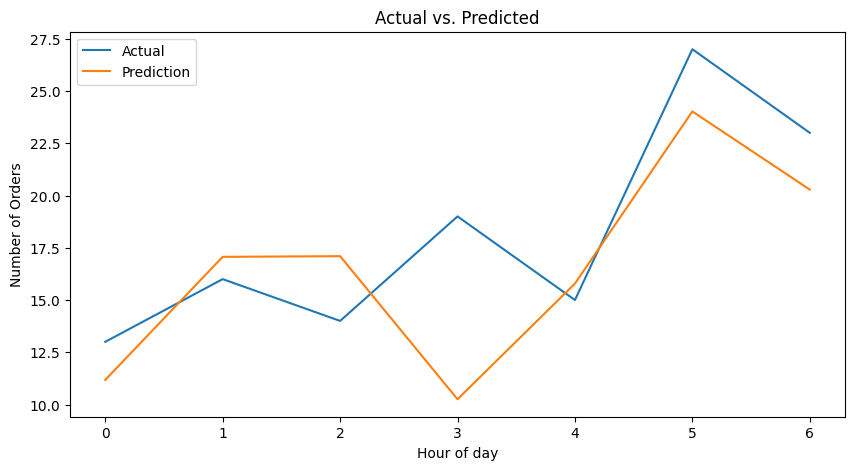

MAE: 3.0304942753614132
MSE: 15.346576721129315
RMSE: 3.917470704565551
R-squared: 0.33216495618531394


In [271]:
# Plot predictions and evaluate model performance
plot_predictions(range(pred_len), y_test, prediction)
evaluate_model(y_test, prediction)

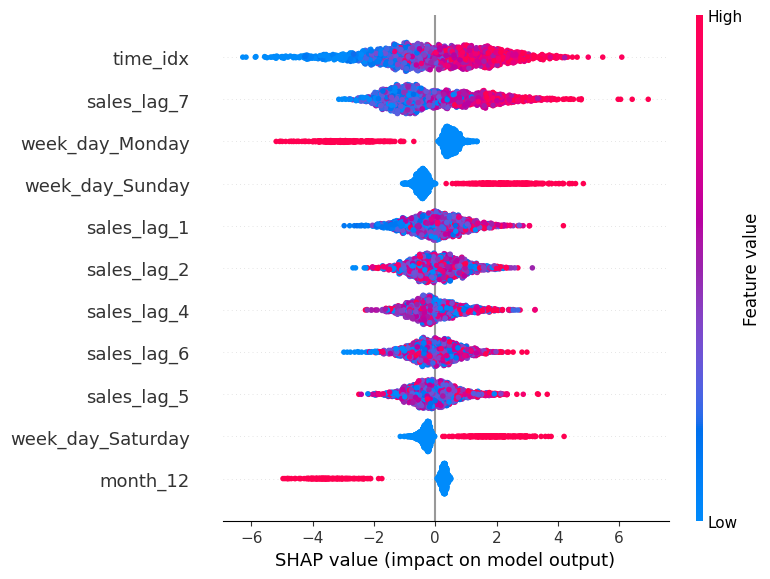

In [157]:
# Use SHAP (SHapley Additive exPlanations) for explaining predictions
explainer = shap.Explainer(model)

# Generate SHAP values for the training data
shap_values = explainer.shap_values(X_train)

# Extract feature names from the training data
feature_names = train.columns[1:]

# Summarize the effects of all the features using a summary plot
shap.summary_plot(shap_values, X_train, feature_names=feature_names, max_display=11)

# Weekly Forecasting

In [14]:
df

,date,store,item,sales,day,month,year,weekday,time_idx
0,2013-01-01,1,1,13,1,1,2013,Tuesday,1
1,2013-01-02,1,1,11,2,1,2013,Wednesday,2
2,2013-01-03,1,1,14,3,1,2013,Thursday,3
3,2013-01-04,1,1,13,4,1,2013,Friday,4
4,2013-01-05,1,1,10,5,1,2013,Saturday,5
...,...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,27,12,2017,Wednesday,1822
912996,2017-12-28,10,50,59,28,12,2017,Thursday,1823
912997,2017-12-29,10,50,74,29,12,2017,Friday,1824
912998,2017-12-30,10,50,62,30,12,2017,Saturday,1825


In [222]:
df_week = df[(df['store']==1) &(df['item']==1)]

df_week = df_week.resample('W-Mon', on='date')['sales'].sum().reset_index()
df_week['time_idx'] = range(1, len(df_week) + 1)

df_week['month'] = df_week['date'].dt.month
df_week['year'] = df_week['date'].dt.year
df_week = df_week[:-1]
df_week

,date,sales,time_idx,month,year
0,2013-01-07,83,1,1,2013
1,2013-01-14,68,2,1,2013
2,2013-01-21,76,3,1,2013
3,2013-01-28,73,4,1,2013
4,2013-02-04,89,5,2,2013
...,...,...,...,...,...
255,2017-11-27,166,256,11,2017
256,2017-12-04,130,257,12,2017
257,2017-12-11,139,258,12,2017
258,2017-12-18,116,259,12,2017


In [223]:
df_pretrain = df_week.copy()

# One-hot encoding 'order_hour'
df_pretrain = pd.get_dummies(df_pretrain, columns=['month'], prefix='month')
df_pretrain = pd.get_dummies(df_pretrain, columns=['year'], prefix='year')

# Converting boolean columns to integer
df_pretrain[df_pretrain.select_dtypes(include=bool).columns] = df_pretrain.select_dtypes(include=bool).astype(int)
        
df_pretrain.drop(columns=['date'], inplace=True)
df_pretrain.head()

,sales,time_idx,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2013,year_2014,year_2015,year_2016,year_2017
0,83,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,68,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,76,3,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,73,4,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,89,5,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [224]:
# Create lag features for time-series modeling
num_lags = 48 # Number of lag hours for the model
for i in range(1, num_lags + 1):
    df_pretrain[f'nb_order_lag_{i}'] = df_pretrain['sales'].shift(i)

# Drop rows with NaN values due to the lag operation
df_pretrain = df_pretrain.dropna()
df_pretrain.head()

,sales,time_idx,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,nb_order_lag_39,nb_order_lag_40,nb_order_lag_41,nb_order_lag_42,nb_order_lag_43,nb_order_lag_44,nb_order_lag_45,nb_order_lag_46,nb_order_lag_47,nb_order_lag_48
48,97,49,0,0,0,0,0,0,0,0,...,101.000000,90.000000,75.000000,74.000000,84.000000,89.000000,73.000000,76.000000,68.000000,83.000000
49,85,50,0,0,0,0,0,0,0,0,...,94.000000,101.000000,90.000000,75.000000,74.000000,84.000000,89.000000,73.000000,76.000000,68.000000
50,74,51,0,0,0,0,0,0,0,0,...,124.000000,94.000000,101.000000,90.000000,75.000000,74.000000,84.000000,89.000000,73.000000,76.000000
51,93,52,0,0,0,0,0,0,0,0,...,107.000000,124.000000,94.000000,101.000000,90.000000,75.000000,74.000000,84.000000,89.000000,73.000000
52,100,53,1,0,0,0,0,0,0,0,...,139.000000,107.000000,124.000000,94.000000,101.000000,90.000000,75.000000,74.000000,84.000000,89.000000


In [225]:
pred_len = 12

In [226]:
# Separating target variable 'nb_order' and features
y = df_pretrain['sales']
X = df_pretrain.drop(columns='sales')

# Scaling features and combining with the target variable
df_scaled = pd.DataFrame(np.column_stack([y, X]), columns=['sales'] + X.columns.tolist())

# Split the data into train and test sets
train_size = int(len(df_scaled) - pred_len)  # Test set is 72 hours
train, test = df_scaled[:train_size], df_scaled[train_size:]

# Separate features and target variable
X_train, y_train = train.drop(columns='sales').values, train['sales'].values
X_test, y_test = test.drop(columns='sales').values, test['sales'].values

In [231]:
# Set hyperparameters
model = lgb.LGBMRegressor(
    force_col_wise=True,
    learning_rate=1,
    n_estimators=100,
    min_data_in_leaf = 0
    )

# Train the model
model.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
[LightGBM] [Info] Total Bins 2689
[LightGBM] [Info] Number of data points in the train set: 200, number of used features: 66
[LightGBM] [Info] Start training from score 144.895000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves t

LGBMRegressor(force_col_wise=True, learning_rate=1, min_data_in_leaf=0)

In [232]:
# Initialize an empty list to store forecasted values
forecast_values = []

# Initialize the current sequence with the first row of the test set
current_sequence = X_test[0:1]

# Loop to predict the next 72 hours 
for _ in range(pred_len):
    # print(current_sequence)

    # Predict the next hour's value using the trained model
    next_hour_pred = model.predict(current_sequence)
    
    # Append the prediction to the forecast values
    forecast_values.append(next_hour_pred[0])


    next_month_pred = model.predict(current_sequence)
    time_idx = current_sequence[0][0] + 1
    month_seq = current_sequence[0][1:13] 
    year_seq = current_sequence[0][13:18]

    # Check if the last element of order_hour is 1 and swap values if true
    if month_seq[-1] == 1:
        month_seq[0], month_seq[-1] = 1, 0
    else:
        month_seq = np.roll(month_seq, 1)

    current_sequence_lag = current_sequence[0][18:]
    current_sequence_lag = np.roll(current_sequence_lag, 1)
    current_sequence_lag[0] = next_month_pred[0]

    current_sequence = [np.concatenate(([time_idx], month_seq, year_seq, current_sequence_lag))]
    
prediction = forecast_values

[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
[LightGBM] [Warning] min_data_in_leaf is

In [233]:
# Function to evaluate model performance
def evaluate_model(y_test, prediction):
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    rmse = np.sqrt(mse)  # Calculate RMSE
    r_squared = r2_score(y_test, prediction)  # Calculate R-squared

    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R-squared: {r_squared}")

# Function to plot actual vs. predicted values
def plot_predictions(testing_hours, y_test, prediction):
  df_test = pd.DataFrame({"hour": testing_hours, "actual": y_test, "prediction": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="hour", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="hour", y="prediction")
  plt.title("Actual vs. Predicted")
  plt.xlabel("Hour of day")
  plt.ylabel("Number of Orders")
  plt.legend(["Actual", "Prediction"])
  plt.show()

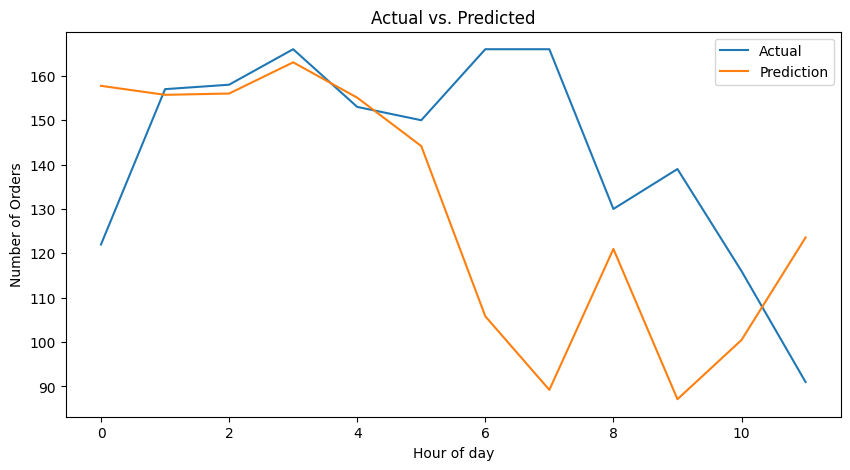

MAE: 24.65106325736789
MSE: 1243.4333783342013
RMSE: 35.26235072048092
R-squared: -1.4005792685167187


In [234]:
# Plot predictions and evaluate model performance
plot_predictions(range(pred_len), y_test, prediction)
evaluate_model(y_test, prediction)

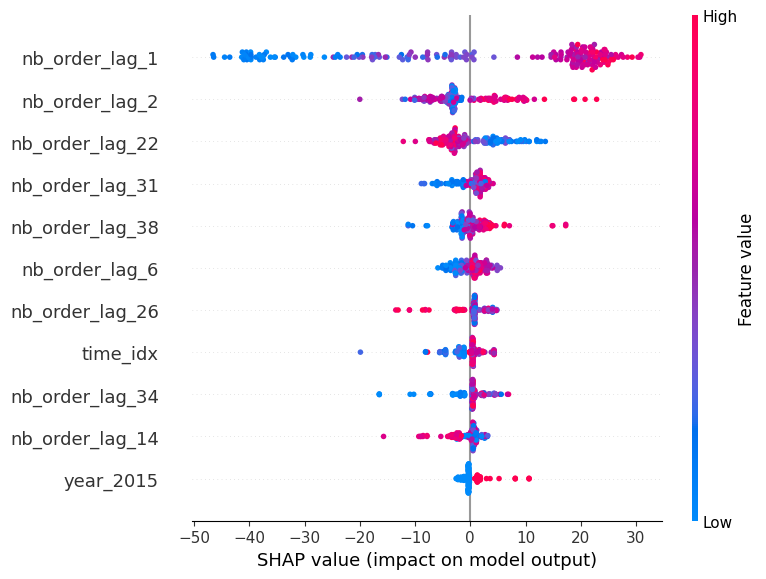

In [235]:
# Use SHAP (SHapley Additive exPlanations) for explaining predictions
explainer = shap.Explainer(model)

# Generate SHAP values for the training data
shap_values = explainer.shap_values(X_train)

# Extract feature names from the training data
feature_names = train.columns[1:]

# Summarize the effects of all the features using a summary plot
shap.summary_plot(shap_values, X_train, feature_names=feature_names, max_display=11)

# Monthly Forecasting

In [7]:
df_month = df.groupby(['store', 'item', 'year', 'month'])['sales'].sum().reset_index()

df_month['date'] = pd.to_datetime(df_month['year'].astype(str) + '-' + df_month['month'].astype(str), format='%Y-%m').dt.to_period('M')

start_date = pd.to_datetime('2013-01', format='%Y-%m')
df_month['time_idx'] = (df_month['date'].dt.year * 12 + df_month['date'].dt.month) - (start_date.year * 12 + start_date.month) + 1

# df_month[['store',	'item']] = df_month[['store',	'item']].astype(str)
df_month

,store,item,year,month,sales,date,time_idx
0,1,1,2013,1,328,2013-01,1
1,1,1,2013,2,322,2013-02,2
2,1,1,2013,3,477,2013-03,3
3,1,1,2013,4,522,2013-04,4
4,1,1,2013,5,531,2013-05,5
...,...,...,...,...,...,...,...
29995,10,50,2017,8,2867,2017-08,56
29996,10,50,2017,9,2586,2017-09,57
29997,10,50,2017,10,2507,2017-10,58
29998,10,50,2017,11,2574,2017-11,59


In [24]:
df_month['sales'].describe()

count    30000.000000
mean      1590.150400
std        824.119569
min        211.000000
25%        925.000000
50%       1449.000000
75%       2112.000000
max       5109.000000
Name: sales, dtype: float64

In [8]:
df_month = df_month[(df_month['store']==1) &(df_month['item']==1)]
print(df_month.shape)
df_month.head()

(60, 7)


,store,item,year,month,sales,date,time_idx
0,1,1,2013,1,328,2013-01,1
1,1,1,2013,2,322,2013-02,2
2,1,1,2013,3,477,2013-03,3
3,1,1,2013,4,522,2013-04,4
4,1,1,2013,5,531,2013-05,5


In [7]:
print(df_month[df_month['year']==2013]['sales'].mean())
print(df_month[df_month['year']==2014]['sales'].mean())
print(df_month[df_month['year']==2015]['sales'].mean())
print(df_month[df_month['year']==2016]['sales'].mean())
print(df_month[df_month['year']==2017]['sales'].mean())

502.0833333333333
574.0833333333334
625.5833333333334
662.5
674.75


In [18]:
df_pretrain = df_month.copy()
# df_pretrain['order_date_new'] = pd.to_datetime(df_pretrain['order_date'])

# One-hot encoding 'order_hour'
df_pretrain = pd.get_dummies(df_pretrain, columns=['month'], prefix='month')
df_pretrain = pd.get_dummies(df_pretrain, columns=['year'], prefix='year')

# Converting boolean columns to integer
df_pretrain[df_pretrain.select_dtypes(include=bool).columns] = df_pretrain.select_dtypes(include=bool).astype(int)
        
df_pretrain.drop(columns=['store', 'item', 'date'], inplace=True)
df_pretrain.head()

,sales,time_idx,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2013,year_2014,year_2015,year_2016,year_2017
0,328,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,322,2,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,477,3,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,522,4,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,531,5,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [19]:
# Create lag features for time-series modeling
num_lags = 12  # Number of lag hours for the model
for i in range(1, num_lags + 1):
    df_pretrain[f'nb_order_lag_{i}'] = df_pretrain['sales'].shift(i)

# Drop rows with NaN values due to the lag operation
df_pretrain = df_pretrain.dropna()
df_pretrain.head()

,sales,time_idx,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,nb_order_lag_3,nb_order_lag_4,nb_order_lag_5,nb_order_lag_6,nb_order_lag_7,nb_order_lag_8,nb_order_lag_9,nb_order_lag_10,nb_order_lag_11,nb_order_lag_12
12,435,13,1,0,0,0,0,0,0,0,...,484.0,519.0,594.0,661.0,627.0,531.0,522.0,477.0,322.0,328.0
13,405,14,0,1,0,0,0,0,0,0,...,572.0,484.0,519.0,594.0,661.0,627.0,531.0,522.0,477.0,322.0
14,549,15,0,0,1,0,0,0,0,0,...,388.0,572.0,484.0,519.0,594.0,661.0,627.0,531.0,522.0,477.0
15,573,16,0,0,0,1,0,0,0,0,...,435.0,388.0,572.0,484.0,519.0,594.0,661.0,627.0,531.0,522.0
16,651,17,0,0,0,0,1,0,0,0,...,405.0,435.0,388.0,572.0,484.0,519.0,594.0,661.0,627.0,531.0


In [20]:
# Separating target variable 'nb_order' and features
y = df_pretrain['sales']
X = df_pretrain.drop(columns='sales')

# Scaling features and combining with the target variable
df_scaled = pd.DataFrame(np.column_stack([y, X]), columns=['sales'] + X.columns.tolist())

# Split the data into train and test sets
train_size = int(len(df_scaled) - 12)  # Test set is 72 hours
train, test = df_scaled[:train_size], df_scaled[train_size:]

# Separate features and target variable
X_train, y_train = train.drop(columns='sales').values, train['sales'].values
X_test, y_test = test.drop(columns='sales').values, test['sales'].values

In [21]:
# Set hyperparameters
model = lgb.LGBMRegressor(
    force_col_wise=True,
    learning_rate=0.1,
    n_estimators=100,
    min_data_in_leaf = 0
    )


# Train the model
model.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
[LightGBM] [Info] Total Bins 199
[LightGBM] [Info] Number of data points in the train set: 36, number of used features: 28
[LightGBM] [Info] Start training from score 620.722222


LGBMRegressor(force_col_wise=True, min_data_in_leaf=0)

In [317]:
pd.set_option('display.float_format', lambda x: format(x, '.6f'))
np.set_printoptions(precision=6, suppress=True)

X_test[0]

array([  49.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.,
        831., 1134., 1076., 1163., 1197., 1443., 1276., 1297., 1113.,
       1001.,  791.,  795.])

In [318]:
test.columns

Index(['sales', 'time_idx', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'year_2013', 'year_2014', 'year_2015',
       'year_2016', 'year_2017', 'nb_order_lag_1', 'nb_order_lag_2',
       'nb_order_lag_3', 'nb_order_lag_4', 'nb_order_lag_5', 'nb_order_lag_6',
       'nb_order_lag_7', 'nb_order_lag_8', 'nb_order_lag_9', 'nb_order_lag_10',
       'nb_order_lag_11', 'nb_order_lag_12'],
      dtype='object')

In [22]:
# Initialize an empty list to store forecasted values
forecast_values = []

# Initialize the current sequence with the first row of the test set
current_sequence = X_test[0:1]

# Loop to predict the next 72 hours 
for _ in range(12):
    # print(current_sequence)

    # Predict the next hour's value using the trained model
    next_hour_pred = model.predict(current_sequence)
    
    # Append the prediction to the forecast values
    forecast_values.append(next_hour_pred[0])


    next_month_pred = model.predict(current_sequence)
    time_idx = current_sequence[0][0] + 1
    month_seq = current_sequence[0][1:13] 
    year_seq = current_sequence[0][13:18]

    # Check if the last element of order_hour is 1 and swap values if true
    if month_seq[-1] == 1:
        month_seq[0], month_seq[-1] = 1, 0
    else:
        month_seq = np.roll(month_seq, 1)

    current_sequence_lag = current_sequence[0][18:]
    current_sequence_lag = np.roll(current_sequence_lag, 1)
    current_sequence_lag[0] = next_month_pred[0]

    current_sequence = [np.concatenate(([time_idx], month_seq, year_seq, current_sequence_lag))]
    
prediction = forecast_values

[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
[LightGBM] [Warning] min_data_in_leaf is

In [31]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to evaluate model performance
def evaluate_model(y_test, prediction):
    # mae = mean_absolute_error(y_test, prediction)
    # mse = mean_squared_error(y_test, prediction)
    # # rmse = np.sqrt(mse)  # Calculate RMSE
    r_squared = r2_score(y_test, prediction)  # Calculate R-squared
    mape = mean_absolute_percentage_error(y_test, prediction)  # Calculate MAPE

    # print(f"MAE: {mae}")
    # print(f"MSE: {mse}")
    # print(f"RMSE: {rmse}")
    print(f"R-squared: {r_squared}")
    print(f"MAPE: {mape}")

# Function to plot actual vs. predicted values
def plot_predictions(testing_hours, y_test, prediction):
  df_test = pd.DataFrame({"hour": testing_hours, "actual": y_test, "prediction": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="hour", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="hour", y="prediction")
  plt.title("Actual vs. Predicted")
  plt.xlabel("Month of day")
  plt.ylabel("Number of Orders")
  plt.legend(["Actual", "Prediction"])
  plt.show()

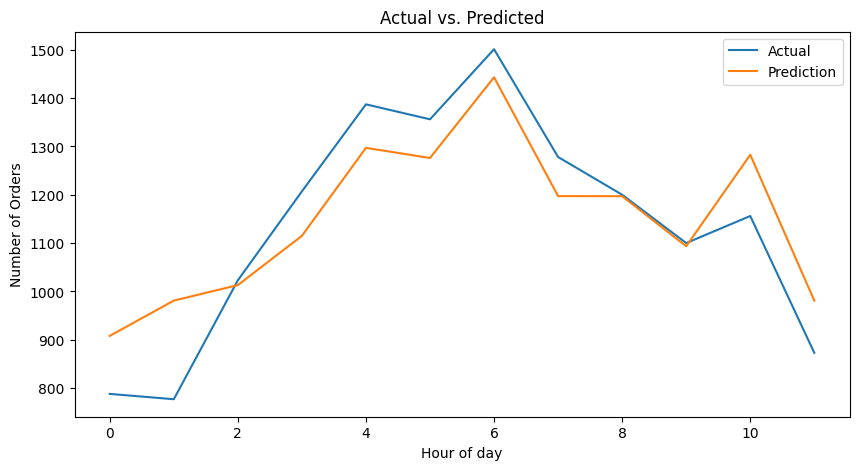

MAE: 81.59760512236447
MSE: 9730.028227753446
RMSE: 98.64090544877133
R-squared: 0.8078112968973674


In [321]:
# Plot predictions and evaluate model performance
plot_predictions(range(12), y_test, prediction)
evaluate_model(y_test, prediction)

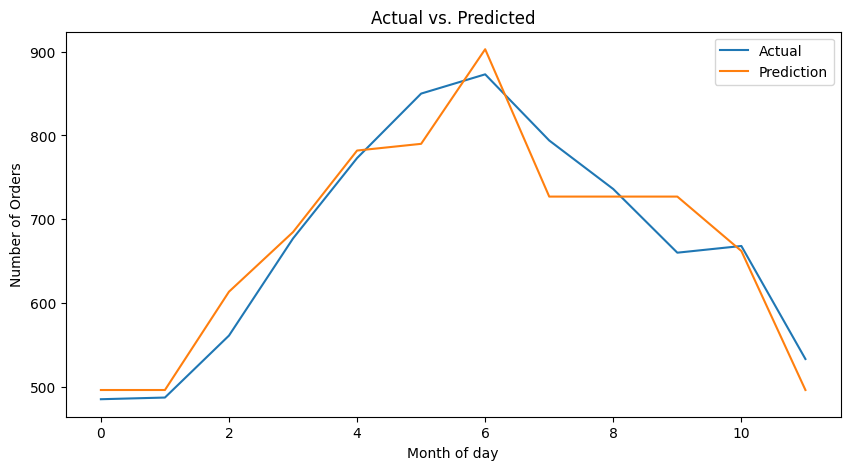

R-squared: 0.9107232142710167
MAPE: 4.4912634702872625


In [32]:
# Plot predictions and evaluate model performance
plot_predictions(range(12), y_test, prediction)
evaluate_model(y_test, prediction)

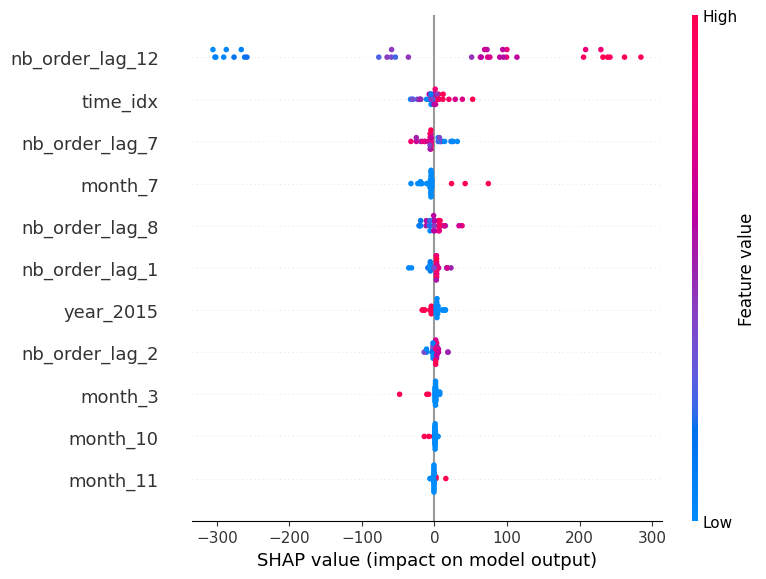

In [322]:
# Use SHAP (SHapley Additive exPlanations) for explaining predictions
explainer = shap.Explainer(model)

# Generate SHAP values for the training data
shap_values = explainer.shap_values(X_train)

# Extract feature names from the training data
feature_names = train.columns[1:]

# Summarize the effects of all the features using a summary plot
shap.summary_plot(shap_values, X_train, feature_names=feature_names, max_display=11)